### Neural Network Classification


# 1. Make classification data and get ready 

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000
#create circles 
X,y = make_circles(n_samples, 
                   noise = 0.03,
                   random_state =42)

In [3]:
len(X) , len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X :\n {X[:5]}")
print(f"First 5 samples of y :\n {y[:5]}")

First 5 samples of X :
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y :
 [1 1 1 1 0]


In [5]:
#make dataframe of circle data 
import pandas as pd 
circles = pd.DataFrame({"X1" : X[: , 0],
                        "X2" : X[:,1],
                        "label" : y})
circles.head

<bound method NDFrame.head of            X1        X2  label
0    0.754246  0.231481      1
1   -0.756159  0.153259      1
2   -0.815392  0.173282      1
3   -0.393731  0.692883      1
4    0.442208 -0.896723      0
..        ...       ...    ...
995  0.244054  0.944125      0
996 -0.978655 -0.272373      0
997 -0.136900 -0.810012      1
998  0.670362 -0.767502      0
999  0.281057  0.963824      0

[1000 rows x 3 columns]>

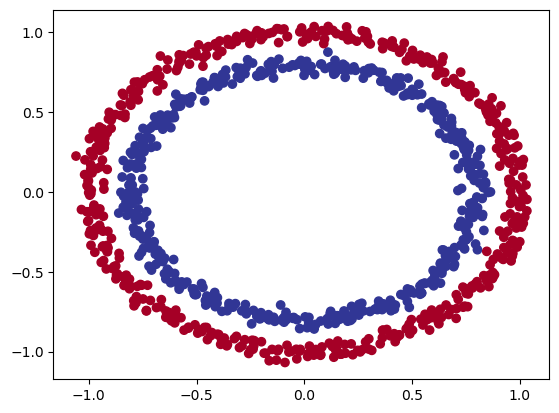

In [6]:
#Visualize 
import matplotlib.pyplot as plt 
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y,
            cmap=plt.cm.RdYlBu);

### This is a toy dataset that illustrate that this is a red dot or a blue dot 

In [7]:
# check input and output shape 
X.shape , y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and lables 
X_sample = X[0]
y_sample=y[0]

X_sample , y_sample



(array([0.75424625, 0.23148074]), 1)

In [10]:
X_sample.shape , y_sample.shape

((2,), ())

In [11]:
# Turn data into tensors and data split 
import torch 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5] , y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,
                                                       y,
                                                       test_size = 0.2, #20% test - 80% train
                                                       random_state = 42)

In [13]:
len(X_train) , len(X_test) , len(y_train) , len(y_test) 

(800, 200, 800, 200)

## 2. Building a model 
1. GPU 
2. subclassing `nn.Module`
3. Loss and optimizer 
4. training and test loop

In [14]:
import torch 
from torch import nn

#Device 
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. `nn.Module`
2. create 2 `nn.Linear()`
3. Define `forward()`

In [15]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # create 2 nn.Linear model
        self.layer_1 = nn.Linear(in_features=2 , out_features=5) # look at neural network shape. extend the features in higher number increase the ability to find the patterns.
        self.layer_2 = nn.Linear(in_features=5 , out_features=1) # in features must match the previous out features

    # Define forward ()
    def forward(self , x):
        return self.layer_2(self.layer_1(x))
    
# send it to be trained 
model_0 = CircleModelV0().to(device)
model_0

    
  



CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

### Loss function
* Regression : MAE , MSE
* Classification : cross entropy 
* `torch.nn.BECWithLogitsLoss()`

### Optimizer (for now)
* SGD
* Adam
* `torch.optim()`

In [17]:
# loss
Loss_fn = nn.BCEWithLogitsLoss() # built in sigmoid function activation
# optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)
# Calculate accuracy 
def accuracy_fn(y_true , y_pred):
    correct = torch.eq(y_true , y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc


### Training our model 
1. forward pass 
2. calculate the loss 
3. optimizer zero grad 
4. loss backward(backpropagation)
5. optimizer setup(gradient descent)


##### our model outputs are going to be raw logit. what we do :
* raw logit -> prediction logit -> prediction labels 
* **sigmoid** for cross entropy and **softmax** for multiclass classification 

In [18]:
# view the first outputs of forward pass on test data 
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.4674],
        [0.3421],
        [0.6072],
        [0.4285],
        [0.3081]], device='cuda:0')

In [19]:
# sigmoid 
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6148],
        [0.5847],
        [0.6473],
        [0.6055],
        [0.5764]], device='cuda:0')

* y_pred_probs >= 0.5 , Lable will be 1 
* y_pred_probs < 0.5 , Lable will be 0


In [20]:
# find prediction labels 
y_preds = torch.round(y_pred_probs)
# in full 
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# check for equality 
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# get rid of extra dimention 
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

### build a training and test loop 

In [21]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epochs 
epochs = 1000
# put data to the target device 
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

# Build training and test loop 
for epoch in range(epochs):
    ### training 
    model_0.train()

    # forward pass 
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss 
    # loss = Loss_fn(torch.sigmoid(y_logits),
    #                y_train)
    
    loss = Loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    #optimizer zero grad 
    optimizer.zero_grad()
    # loss backward 
    loss.backward()
    # optimizer step 
    optimizer.step()

    ###testing 
    model_0.eval()
    with torch.inference_mode():
        #forward pass 
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        ## calculate loss 
        test_loss = Loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    # print 
    if epoch % 10 == 0 :
        print(f"epoch : {epoch} | loss : {loss:.5f} | acc : {acc:.2f}% | test loss : {test_loss:.5f} | test acc : {test_acc:.2f}%")

    


epoch : 0 | loss : 0.71729 | acc : 50.00% | test loss : 0.71162 | test acc : 50.00%
epoch : 10 | loss : 0.71500 | acc : 50.00% | test loss : 0.70954 | test acc : 50.00%
epoch : 20 | loss : 0.71296 | acc : 50.00% | test loss : 0.70769 | test acc : 50.00%
epoch : 30 | loss : 0.71112 | acc : 50.00% | test loss : 0.70603 | test acc : 50.00%
epoch : 40 | loss : 0.70948 | acc : 50.00% | test loss : 0.70455 | test acc : 50.00%
epoch : 50 | loss : 0.70800 | acc : 50.00% | test loss : 0.70324 | test acc : 50.00%
epoch : 60 | loss : 0.70668 | acc : 50.00% | test loss : 0.70206 | test acc : 50.00%
epoch : 70 | loss : 0.70549 | acc : 50.00% | test loss : 0.70102 | test acc : 50.00%
epoch : 80 | loss : 0.70442 | acc : 51.62% | test loss : 0.70008 | test acc : 51.00%
epoch : 90 | loss : 0.70346 | acc : 53.62% | test loss : 0.69925 | test acc : 53.00%
epoch : 100 | loss : 0.70259 | acc : 56.00% | test loss : 0.69851 | test acc : 57.50%
epoch : 110 | loss : 0.70181 | acc : 57.63% | test loss : 0.69785

### improving our model 
* add more layers 
* add more hidden units 
* fit for longer 
* changing the activation model 
* changing the learning rate 
* change the loss function 


# None linearity 

In [22]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2,out_features=10)
        self.layer2 = nn.Linear(in_features=10,out_features=10)
        self.layer3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))    

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [23]:
# create  a loss function 
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)


In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate loss and accuracy 
    loss = loss_fn(y_logits , y_train)
    acc = accuracy_fn(y_true=y_train , y_pred= y_pred)
    # optimizer zero grad 
    optimizer.zero_grad()
    # loss backward 
    loss.backward()
    #optimizer step
    optimizer.step()

    ### testing 
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # loss
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test , y_pred= test_pred)

    if epoch % 100 == 0 :
        print (f"epoch : {epoch} | loss : {loss:.4f} | Acc : {acc:.2f}% | Test loss : {test_loss:.4f}| test acc : {test_acc:.2f}% ")

epoch : 0 | loss : 0.6929 | Acc : 50.00% | Test loss : 0.6932| test acc : 50.00% 
epoch : 100 | loss : 0.6912 | Acc : 52.88% | Test loss : 0.6910| test acc : 52.50% 
epoch : 200 | loss : 0.6898 | Acc : 53.37% | Test loss : 0.6894| test acc : 55.00% 
epoch : 300 | loss : 0.6879 | Acc : 53.00% | Test loss : 0.6872| test acc : 56.00% 
epoch : 400 | loss : 0.6852 | Acc : 52.75% | Test loss : 0.6841| test acc : 56.50% 
epoch : 500 | loss : 0.6810 | Acc : 52.75% | Test loss : 0.6794| test acc : 56.50% 
epoch : 600 | loss : 0.6751 | Acc : 54.50% | Test loss : 0.6729| test acc : 56.00% 
epoch : 700 | loss : 0.6666 | Acc : 58.38% | Test loss : 0.6632| test acc : 59.00% 
epoch : 800 | loss : 0.6516 | Acc : 64.00% | Test loss : 0.6476| test acc : 67.50% 
epoch : 900 | loss : 0.6236 | Acc : 74.00% | Test loss : 0.6215| test acc : 79.00% 


## Multi-class problem ##

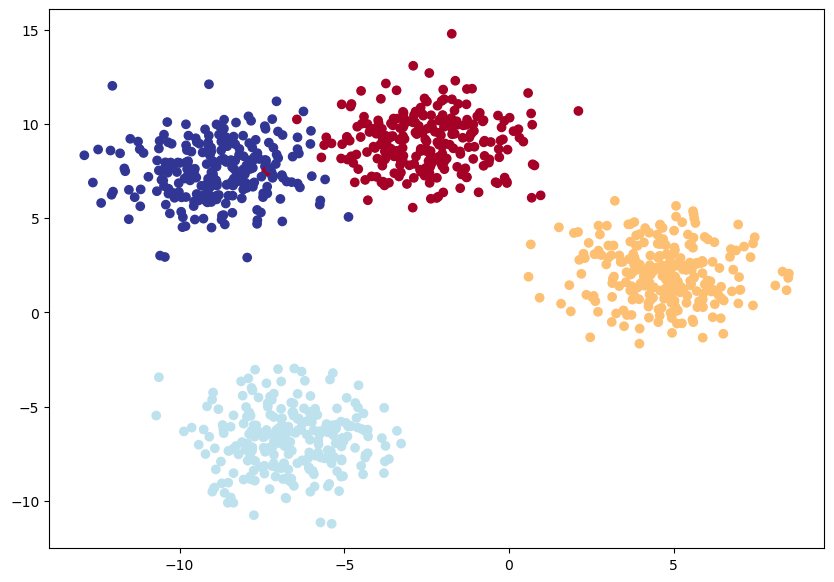

In [25]:
# data set 
import torch 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# hyper-parameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

#create the data 
X_blob , y_blob = make_blobs(n_samples=1000,
                             n_features=NUM_FEATURES,
                             centers=NUM_CLASSES,
                             cluster_std = 1.5 , 
                             random_state=RANDOM_SEED)

# turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# train and test split 
X_blob_train , X_blob_test , y_blob_train , y_blob_test = train_test_split(X_blob,
                                                                           y_blob,
                                                                           test_size= 0.2,
                                                                           random_state = RANDOM_SEED)

#plot the dataset
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1] , c=y_blob , cmap=plt.cm.RdYlBu) ;





In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [27]:
class BlobModel(nn.Module):
    def __init__(self, input_features , output_features , hidden_units = 8 ):
        """Initializing multi-class classification model.

        Args:
          input_features(int)
          output_features(int)
          hidden_units(int) : default 8

        """

        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features , out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units , out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units , out_features= output_features)
        )
    def forward (self , x ):
        return self.linear_layer_stack(x)
        

Model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

Model_4
        

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [28]:
X_blob_train.shape , y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [29]:
# creat a loss function and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Model_4.parameters(),
                            lr = 0.1)


1. logits 
2. pred prob 
3. pred lable 

In [30]:
#training loop 
Model_4.eval()
with torch.inference_mode():
    y_logits = Model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [31]:
#normalize the logits 
y_pred_probs= torch.softmax(y_logits , dim=1)
# convert them in prediction lables 
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [32]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

In [33]:
y_blob_train.dtype

torch.float32

In [34]:
### training and testing loop
torch.manual_seed = 42
torch.cuda.manual_seed = 42

epochs = 1000

X_blob_train , y_blob_train = X_blob_train.to(device) , y_blob_train.to(device)
X_blob_test , y_blob_test = X_blob_test.to(device) , y_blob_test.to(device)


# Convert targets to LongTensor
y_blob_train = y_blob_train.long()
y_blob_test = y_blob_test.long()


for epoch in range(epochs):

    Model_4.train()

    y_logits = Model_4(X_blob_train)
    y_pred = torch.softmax(y_logits , dim =1).argmax(dim=1)

    loss = loss_fn(y_logits , y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # testing 
    Model_4.eval()
    with torch.inference_mode():
        test_logits = Model_4(X_blob_test)
        test_pred = torch.softmax(test_logits , dim = 1).argmax(dim = 1)

        test_loss = loss_fn(test_logits , y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
        
    # print
    if epoch % 100 == 0 :
        print (f"epoch : {epoch} | loss : {loss:.4f} | Acc : {acc:.2f}% | Test loss : {test_loss:.4f}| test acc : {test_acc:.2f}% ")



epoch : 0 | loss : 1.1588 | Acc : 40.38% | Test loss : 1.0755| test acc : 48.00% 
epoch : 100 | loss : 0.0331 | Acc : 99.25% | Test loss : 0.0243| test acc : 99.50% 
epoch : 200 | loss : 0.0266 | Acc : 99.25% | Test loss : 0.0165| test acc : 99.50% 
epoch : 300 | loss : 0.0250 | Acc : 99.25% | Test loss : 0.0144| test acc : 99.50% 
epoch : 400 | loss : 0.0243 | Acc : 99.25% | Test loss : 0.0134| test acc : 99.50% 
epoch : 500 | loss : 0.0238 | Acc : 99.25% | Test loss : 0.0127| test acc : 99.50% 
epoch : 600 | loss : 0.0234 | Acc : 99.25% | Test loss : 0.0122| test acc : 99.50% 
epoch : 700 | loss : 0.0231 | Acc : 99.25% | Test loss : 0.0118| test acc : 99.50% 
epoch : 800 | loss : 0.0228 | Acc : 99.25% | Test loss : 0.0115| test acc : 99.50% 
epoch : 900 | loss : 0.0225 | Acc : 99.25% | Test loss : 0.0112| test acc : 99.50% 


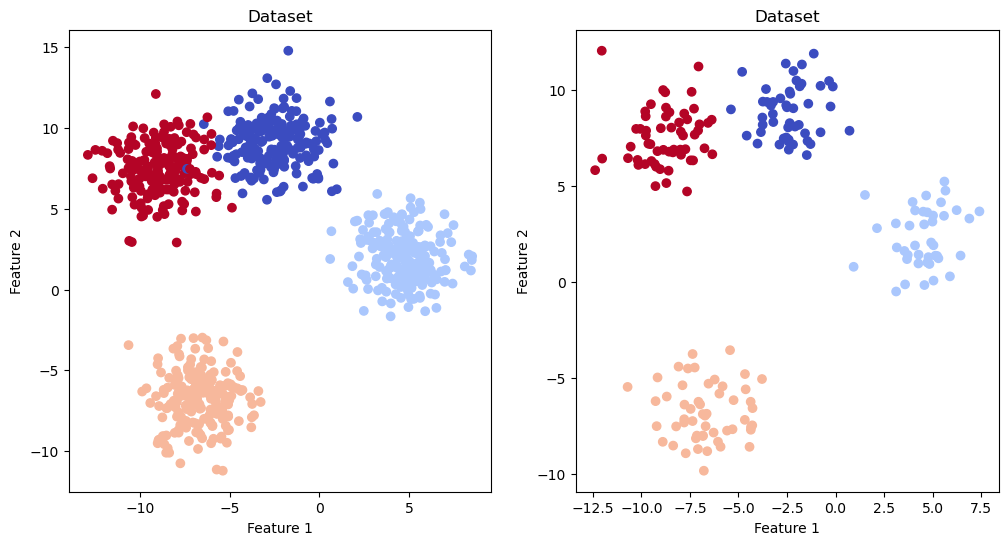

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dataset(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Dataset")

# Ensure tensors are on CPU for visualization
X_blob_train = X_blob_train.cpu()
y_blob_train = y_blob_train.cpu()
X_blob_test = X_blob_test.cpu()
y_blob_test = y_blob_test.cpu()

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_dataset(X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_dataset(X_blob_test, y_blob_test)

plt.show()


In [37]:
!pip install torchmetrics

  Using cached torchmetrics-1.4.2-py3-none-any.whl.metadata (19 kB)
  Using cached lightning_utilities-0.11.7-py3-none-any.whl.metadata (5.2 kB)
Using cached torchmetrics-1.4.2-py3-none-any.whl (869 kB)
Using cached lightning_utilities-0.11.7-py3-none-any.whl (26 kB)
